# Reanalysis of the extrusion data

In this notebook, I plan to add a few new elements to the extrusion data, namely:

1. new definition of the crossover from linear to nonlinear regime
2. correlation between exit temperature and the extrusion rate-force linearity
3. correlation between extrusion efficiency and the extrusion rate-force linearity

So clearly, we need to determine the linear regime first. 

## 0 Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from pathlib import Path
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors

## 1 Determine linear regime

The original crossover was determined by fitting two lines to the linear regime and the nonlinear regime, and use the intersecting point as the crossover. However, since the nonlinear regime is not expected to be well-fitted by a line, this fitting could introduce arbitrariness to the analysis. 

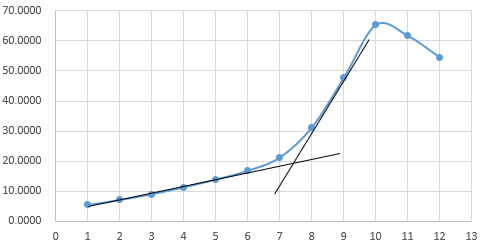

Here, I introduce an alternative approach, which does not rely on fitting the nonlinear regime. The basic work flow is to 
1. fit the first 3 points with a line, evaluate the mean error of the fit
2. if the mean error of the fit is below certain threshold, go on to fit the first 4 points, and evaluate the mean error
3. if the mean error is below the threshold continue to fit 5, 6, 7 points, until the mean error is greater than the threshold
4. use the number of points used as the linear regime. 

In [96]:
data_folder = Path("../Data").resolve()
data = pd.read_excel(data_folder / "挤出测试平台数据.xlsx")

In [10]:
data

,速度,压力均值,压力标准差,压力均值.1,压力标准差.1,实际挤出量,设定挤出量,挤出效率,挤出效率校准,出口温度,设定温度,材料
0,1,0.5527,0.0920,5.41646,0.90160,101.40,100,1.014000,1.000000,190.0,190,L1002
1,2,0.7193,0.0153,7.04914,0.14994,202.75,200,1.013750,0.999753,189.0,190,L1002
2,3,0.9171,0.0169,8.98758,0.16562,303.53,300,1.011767,0.997798,188.0,190,L1002
3,4,1.1502,0.0209,11.27196,0.20482,404.22,400,1.010550,0.996598,186.0,190,L1002
4,5,1.4149,0.0281,13.86602,0.27538,503.92,500,1.007840,0.993925,183.0,190,L1002
...,...,...,...,...,...,...,...,...,...,...,...,...
284,11,2.4536,0.0930,24.04528,0.91140,1115.70,1100,1.014273,0.981586,NaN,250,Esun PLA
285,12,3.2790,0.1315,32.13420,1.28870,1207.14,1200,1.005950,0.973531,NaN,250,Esun PLA
286,13,4.2499,0.1512,41.64902,1.48176,1288.77,1300,0.991362,0.959413,NaN,250,Esun PLA
287,14,5.1143,1.0429,50.12014,10.22042,1352.23,1400,0.965879,0.934751,NaN,250,Esun PLA


In [11]:
df = data.loc[(data["材料"]=="L1002")&(data["设定温度"]==190)]
df

,速度,压力均值,压力标准差,压力均值.1,压力标准差.1,实际挤出量,设定挤出量,挤出效率,挤出效率校准,出口温度,设定温度,材料
0,1,0.5527,0.0920,5.41646,0.90160,101.40,100,1.014000,1.000000,190.0,190,L1002
1,2,0.7193,0.0153,7.04914,0.14994,202.75,200,1.013750,0.999753,189.0,190,L1002
2,3,0.9171,0.0169,8.98758,0.16562,303.53,300,1.011767,0.997798,188.0,190,L1002
3,4,1.1502,0.0209,11.27196,0.20482,404.22,400,1.010550,0.996598,186.0,190,L1002
4,5,1.4149,0.0281,13.86602,0.27538,503.92,500,1.007840,0.993925,183.0,190,L1002
5,6,1.7148,0.0331,16.80504,0.32438,603.81,600,1.006350,0.992456,180.0,190,L1002
6,7,2.1651,0.0559,21.21798,0.54782,701.15,700,1.001643,0.987813,178.0,190,L1002
7,8,3.1885,0.1373,31.24730,1.34554,795.04,800,0.993800,0.980079,177.0,190,L1002
8,9,4.8753,0.2334,47.77794,2.28732,869.12,900,0.965689,0.952356,179.0,190,L1002
9,10,6.6672,0.2741,65.33856,2.68618,905.45,1000,0.905450,0.892949,179.0,190,L1002


(0.0, 70.0)

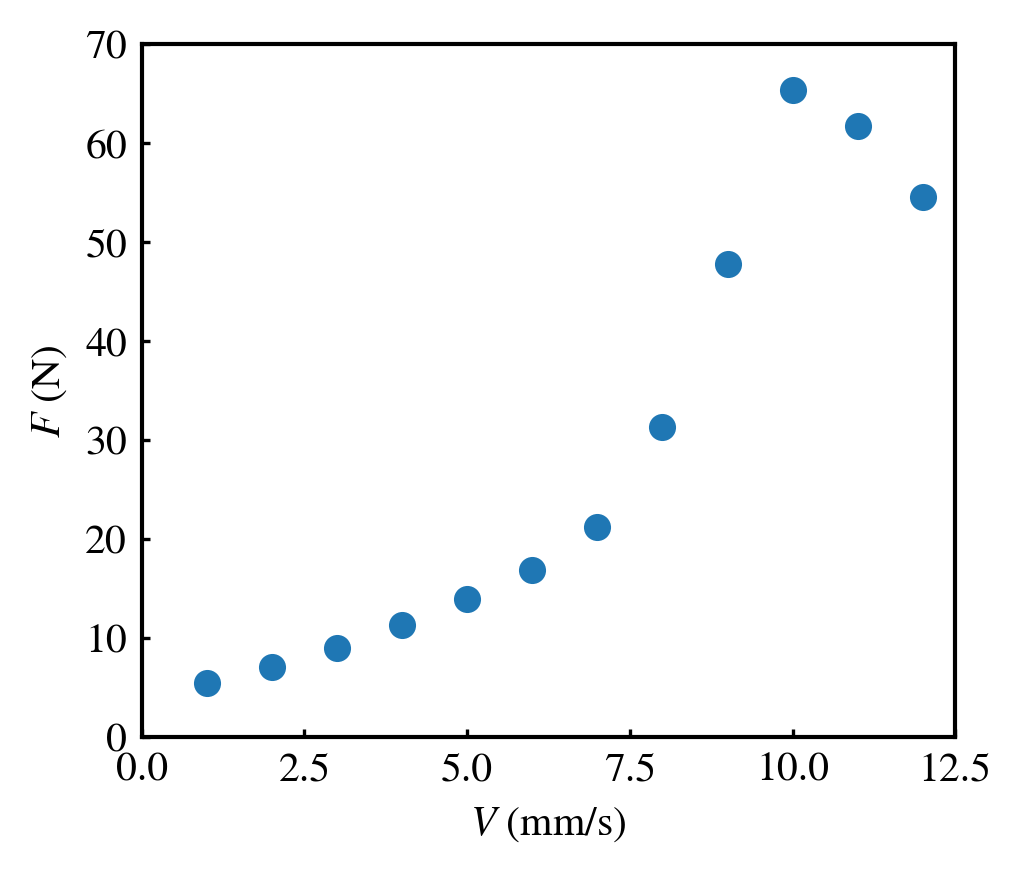

In [12]:
plt.figure(dpi=300)
plt.plot(df["速度"], df["压力均值.1"], "o")
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)

### 1.1 Fit a subset with a line

We can fit a line to the linear regime. However, we need to carefully consider whether we should use a line that crosses (0, 0) or not. Ideally, this line should cross (0, 0), as we can imagine that if we apply a infinitely small velocity to the filament, the force should also vanish. The data itself starts at $V=1$ mm/s, a relatively large velocity, so this point cannot be tested directly by the data. Extrapolating the small $V$ regime to $V=0$ results in an intersection larger than 0. This offset suggests that, even if we don't extrude, some force is applied to the hotend. This is clearly unphysical and is worth understanding. Two hypotheses come to my mind:

1. The device is not properly zeroed before experiment, which introduces an offset;
2. There is a different flow regime at very low velocity.

Pending expermental evidence.

In [114]:
# define linear functions
def linear(x, a):
    return a * x
def linear_offset(x, a, b):
    return a * x + b

In [15]:
nPoints = 3
x = df["速度"][:nPoints]
y = df["压力均值.1"][:nPoints]

In [16]:
popt, pcov = curve_fit(linear_offset, x, y)

Text(0, 0.5, '$F$ (N)')

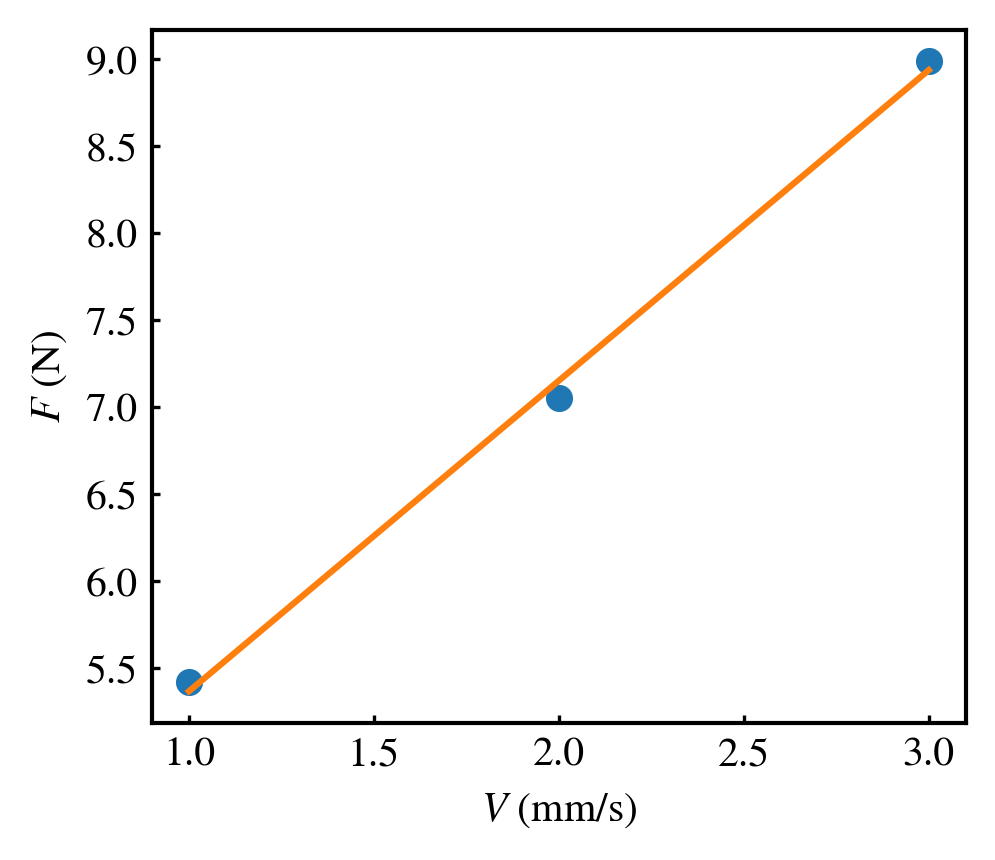

In [19]:
plt.plot(x, y, "o")
plt.plot(x, linear_offset(x, *popt))
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")

In [18]:
mean_err = ((y - linear_offset(x, *popt)) ** 2).sum() / nPoints / np.mean(y)**2
mean_err

np.float64(0.00010156591617630314)

(0.0, 70.0)

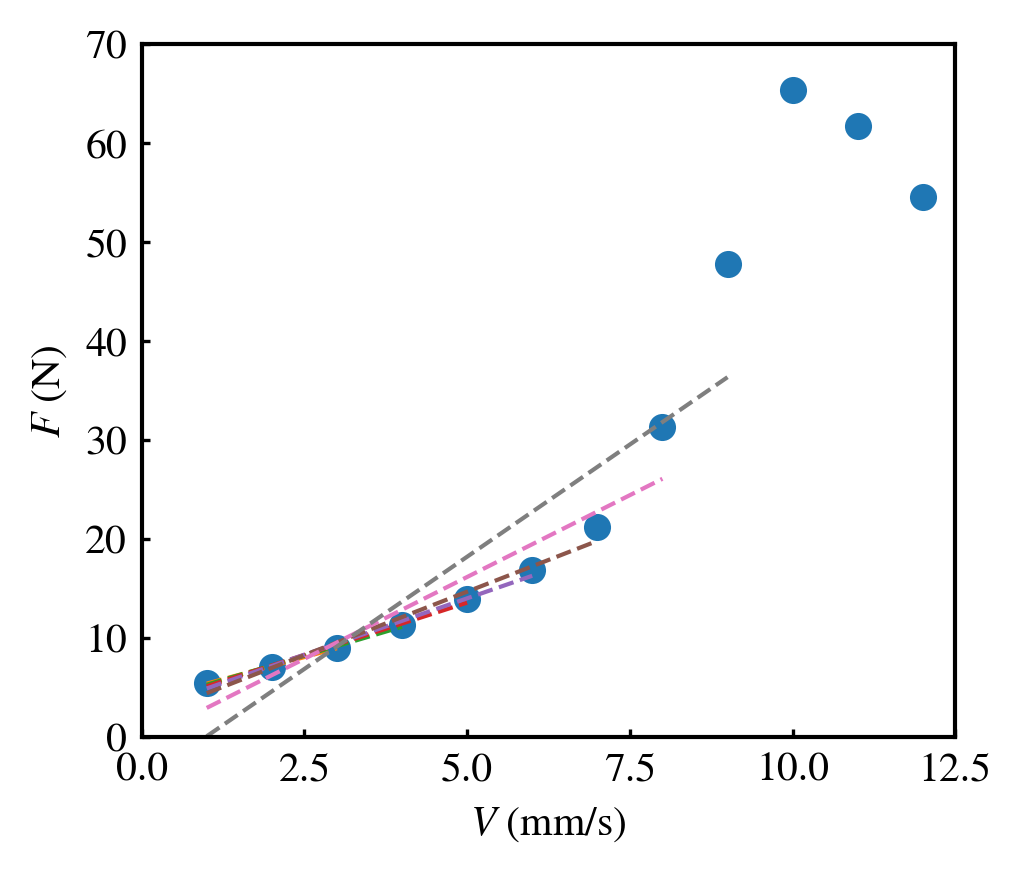

In [87]:
nPoints_list = range(3, 10)
mean_err_list = []
plt.plot(df["速度"], df["压力均值.1"], "o")
for nPoints in nPoints_list:
    x = df["速度"][:nPoints]
    y = df["压力均值.1"][:nPoints]
    popt, pcov = curve_fit(linear_offset, x, y)
    mean_err = ((y - linear_offset(x, *popt)) ** 2).sum() / nPoints / np.mean(y)**2
    plt.plot(x, linear_offset(x, *popt), lw=1, ls="--")
    mean_err_list.append(mean_err)
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)

Text(0, 0.5, 'Normalized mean square error, $\\left<\\delta y^2\\right>$')

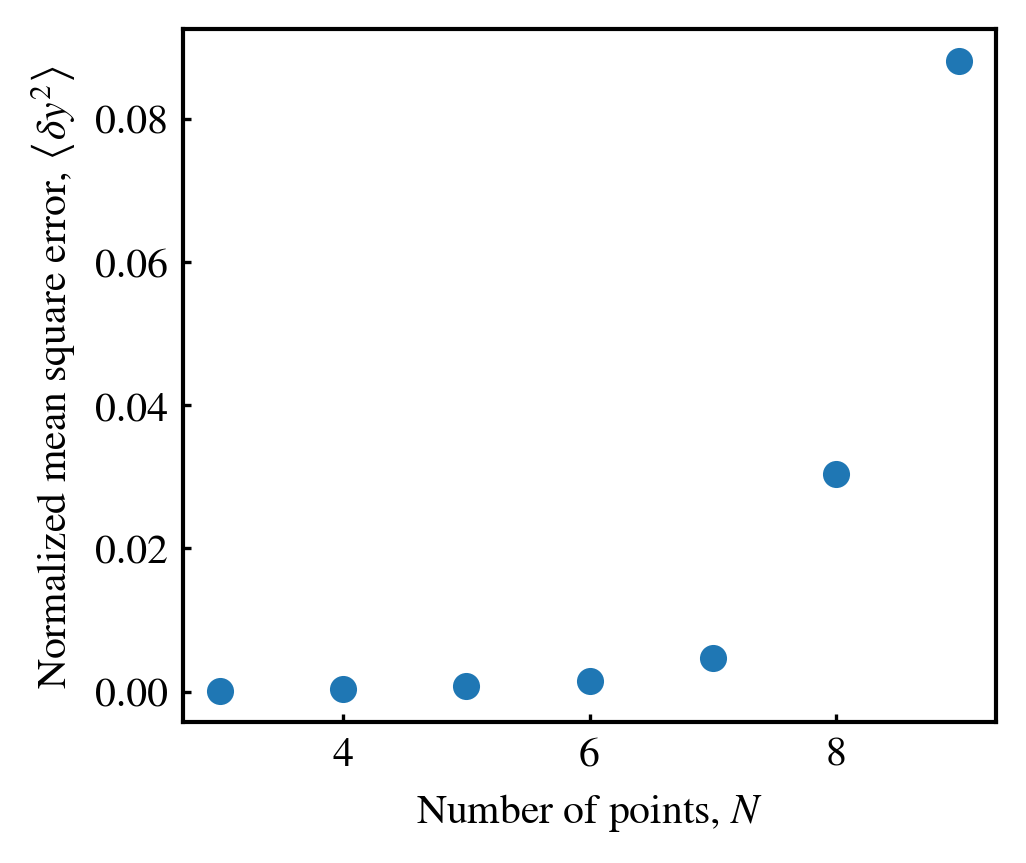

In [86]:
plt.plot(nPoints_list, mean_err_list, "o")
plt.xlabel("Number of points, $N$")
plt.ylabel("Normalized mean square error, $\\left<\\delta y^2\\right>$")

For the first data set, the procedure works fine, as we can clearly see a jump in the mean error between 7 points and 8 points. This suggests that using the fitting error as the criterion for determining linear regime is a good idea. Tentatively, we set the threshold for the normalized mean square error at 0.01, beyond which we regard as the "nonlinear" regime. 

Using this criterion, we can process multiple data sets to obtain some statistics.

### 1.2 Plot multiple temperature data sets

In the mean time, we can compare our experimental data with Serdeczny 2020 and analyze the differences.

In [46]:
data_folder = Path("../Data").resolve()
data = pd.read_excel(data_folder / "挤出测试平台数据.xlsx")
serdeczny_pla = pd.read_excel(data_folder / "Serdeczny2020" / "PLA.xlsx")

(0.0, 70.0)

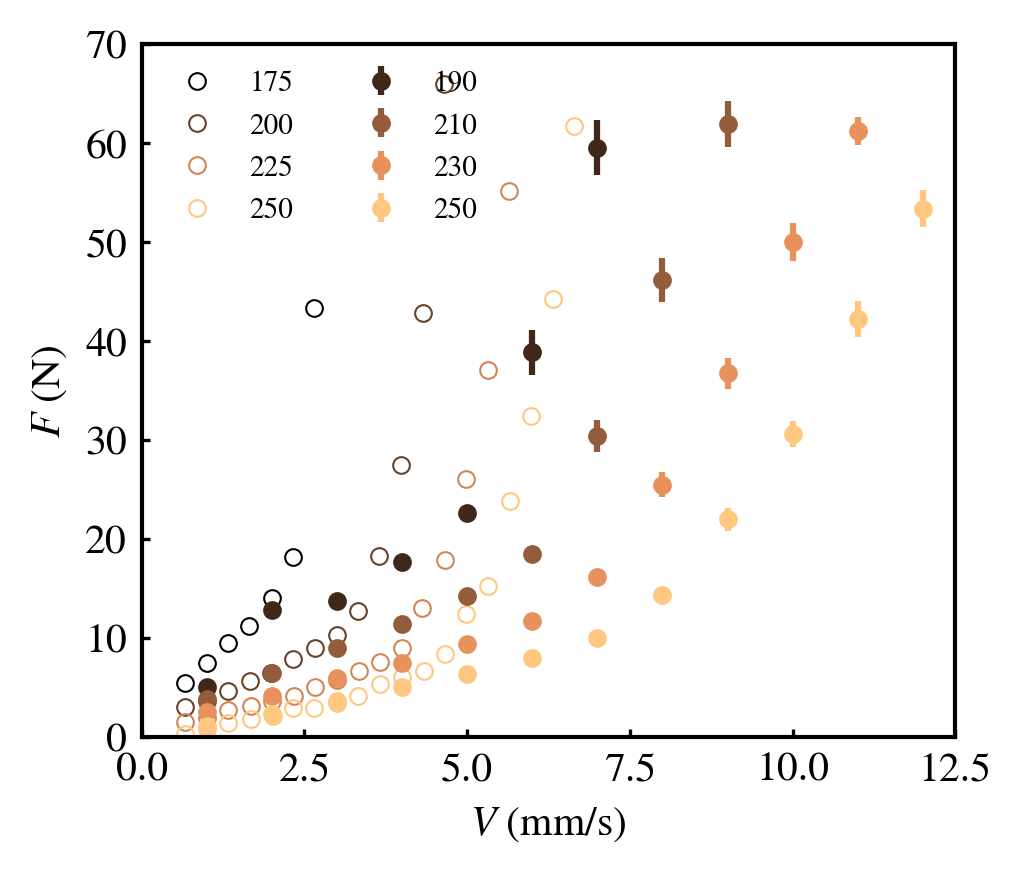

: 

In [ ]:
df = data.loc[data["材料"]=="L1003"]
df2 = serdeczny_pla
cmap = plt.get_cmap("copper")
tmin = 175
tmax = 250
for T, g in df.groupby("设定温度"):
    color = cmap( (T-tmin) / (tmax-tmin) )
    plt.errorbar(g["速度"], g["压力均值.1"], yerr=g["压力标准差.1"], color=color, marker="o", ls="", markersize=4, label=T)
for T, g in df2.groupby("设定温度"):
    color = cmap( (T-tmin) / (tmax-tmin) )
    plt.plot(g["速度"]/60, g["压力均值"], mec=color, mfc=(0,0,0,0), marker="o", ls="", markersize=4, label=T)

plt.legend(loc="upper left", ncol=2, fontsize=7)
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)

## 2 Critical extrusion speed

We define the critical extrusion speed as the speed where the mean square error of the linear fit is greater than a threshold value, tentatively 0.01.

### 2.1 Fit all data

In [109]:
data_folder = Path("../Data").resolve()
data = pd.read_excel(data_folder / "挤出测试平台数据.xlsx")

In [84]:
fit_results = {}
mse_thres = 0.01
for mat, gmat in data.groupby("材料"):
    fit_results[mat] = {}
    for T, g in gmat.groupby("设定温度"):
        nPoints_list = range(3, len(g))
        vmax_list = []
        mean_err_list = []
        for nPoints in nPoints_list:
            x = g["速度"][:nPoints]
            y = g["压力均值.1"][:nPoints]
            popt, pcov = curve_fit(linear_offset, x, y)
            mean_err = ((y - linear_offset(x, *popt)) ** 2).sum() / nPoints / np.mean(y)**2
            # plt.plot(x, linear_offset(x, *popt), lw=1, ls="--")
            vmax_list.append(x.max())
            mean_err_list.append(mean_err)
        fit_results[mat][T] = pd.DataFrame({"velocity": vmax_list, "mean_err": mean_err_list})

In [134]:
def find_force_transition_velocity(df, velocity_col_name="速度", force_col_name="挤出力", thres=0.01):
    """Fit linear function to the extrusion force data and find the transition from slow increase regime to fast increase regime by identifying the first bad linear fit. 
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the velocity and force data to be analyzed.
    velocity_col_name : str, optional
        Name of the column containing velocity data, by default "速度"
    force_col_name : str, optional
        Name of the column containing force data, by default "挤出力"
    thres : float, optional
        Threshold for the mean squared error to identify bad linear fit, by default 0.01
    
    Returns
    -------
    float
        The velocity at which the transition occurs, or None if not found.
    """

    nPoints_list = range(3, len(df))
    vmax_list = []
    mean_err_list = []
    for nPoints in nPoints_list:
        x = df[velocity_col_name][:nPoints]
        y = df[force_col_name][:nPoints]
        popt, pcov = curve_fit(linear_offset, x, y)
        mean_err = ((y - linear_offset(x, *popt)) ** 2).sum() / nPoints / np.mean(y)**2
        # plt.plot(x, linear_offset(x, *popt), lw=1, ls="--")
        vmax_list.append(x.max())
        mean_err_list.append(mean_err)

    x = np.array(vmax_list)
    y = np.array(mean_err_list)
    if len(x) > 2:
        cs = CubicSpline(x, y, bc_type="natural")
        x_fine = np.linspace(x.min(), x.max(), 100)
        y_fine = cs(x_fine)
        transition_points = x_fine[y_fine > thres]
        if len(transition_points) > 0:
            return transition_points[0]
        else:
            return None
    else:
        raise ValueError("Not enough data points to perform cubic spline interpolation.")

In [139]:
df = data.loc[(data["材料"]=="L1002")&(data["设定温度"]==190)]
find_force_transition_velocity(df, force_col_name="压力均值.1", thres=0.01)

np.float64(7.363636363636364)

### 2.2 Find critical point programatically

Interpolate the MSE vs. nPoints curve with a cubic spline and determine the 

In [ ]:
df = fit_results["Bambu PLA"][190]
x = df["velocity"]
y = df["mean_err"]

In [ ]:
cs = CubicSpline(x, y, bc_type="natural")

In [ ]:
x_fine = np.linspace(x.min(), x.max())
y_fine = cs(x_fine)

In [ ]:
v_crit = x_fine[np.argmin(np.abs(y_fine - 0.01))]
v_crit

np.float64(7.285714285714286)

Use this method to loop over all data.

In [ ]:
mse_thres = 0.01

critical_speed = {}
for mat in fit_results:
    T_list = []
    cs_list = []
    for T in fit_results[mat]:
        df = fit_results[mat][T]
        x = df["velocity"]
        y = df["mean_err"]
        cs = CubicSpline(x, y, bc_type="natural")
        x_fine = np.linspace(x.min(), x.max())
        y_fine = cs(x_fine)
        v_crit = x_fine[np.argmin(np.abs(y_fine - mse_thres))]
        T_list.append(T)
        cs_list.append(v_crit)
    critical_speed[mat] = pd.DataFrame({"temperature": T_list, "critical_speed": cs_list})

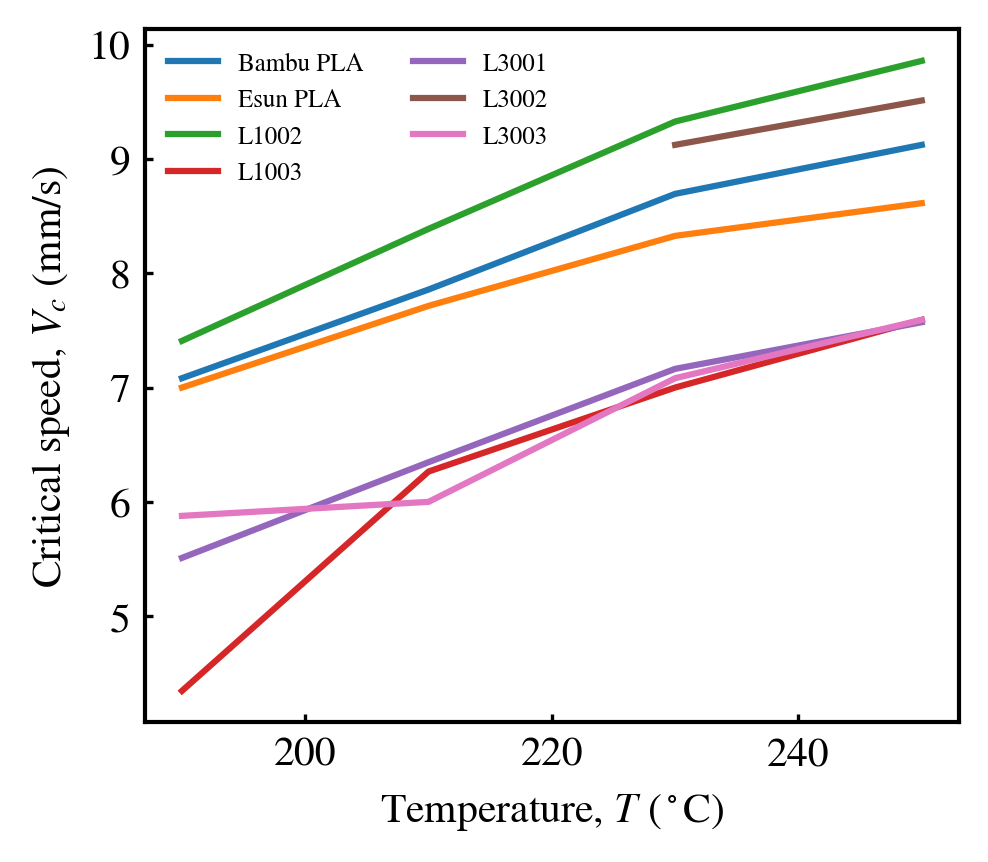

In [95]:
for mat in critical_speed:
    df = critical_speed[mat]
    plt.plot(df["temperature"], df["critical_speed"], label=mat)
plt.xlabel("Temperature, $T$ ($^\\circ$C)")
plt.ylabel("Critical speed, $V_c$ (mm/s)")
plt.legend(loc="upper left", fontsize=6, ncol=2)

## 3 Exit temperature analysis

We hypothesize that the transition from linear to nonlinear regime is due to insufficient heating of the melt in the nozzle. To directly visualize the relation between force regime and exit temperature, we plot the force-velocity relation, using exit temperature as the color. Below is an example. 

In [3]:
data_folder = Path("../Data").resolve()
data = pd.read_excel(data_folder / "挤出测试平台数据.xlsx")

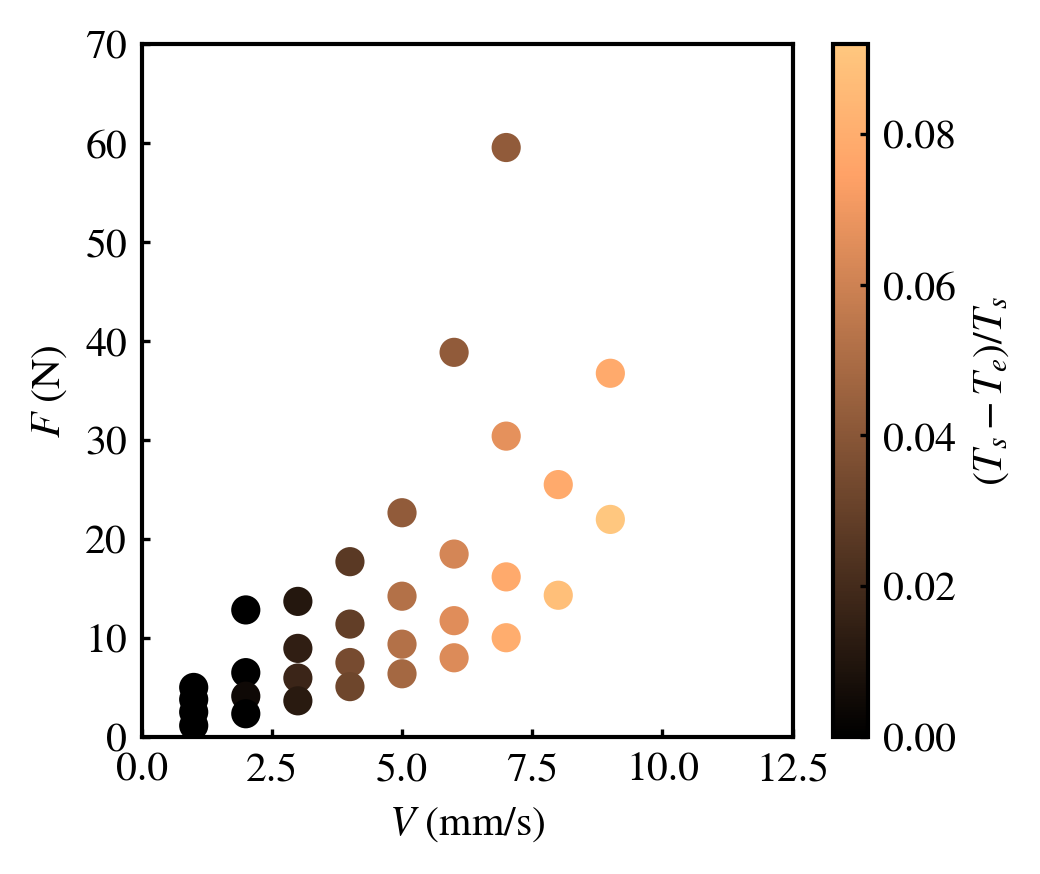

In [4]:
df = data.loc[data["材料"]=="L1003"]

cmap = plt.get_cmap("copper")
plt.scatter(df["速度"], df["压力均值.1"], c=(df["设定温度"]-df["出口温度"])/df["设定温度"], cmap=cmap, marker="o")
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)
plt.colorbar(label="$(T_s-T_e)/T_s$")

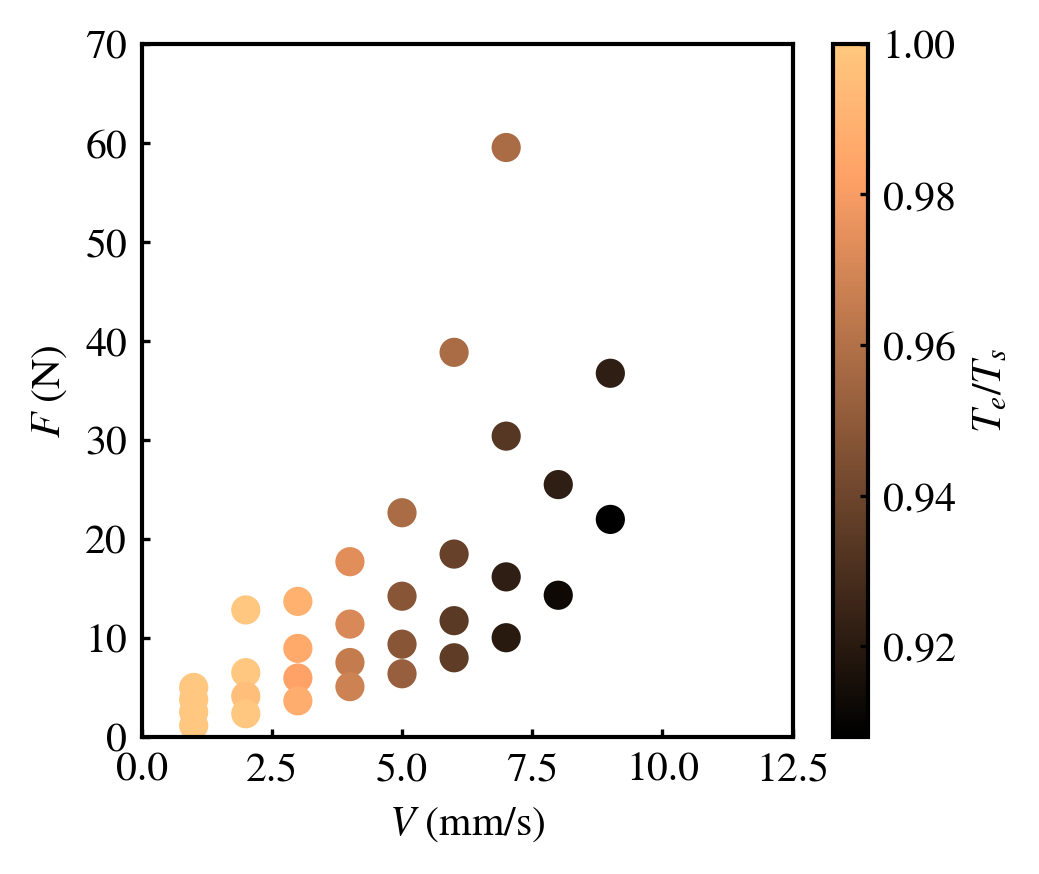

In [113]:
df = data.loc[data["材料"]=="L1003"]

cmap = plt.get_cmap("copper")
plt.scatter(df["速度"], df["压力均值.1"], c=df["出口温度"]/df["设定温度"], cmap=cmap, marker="o")
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)
plt.colorbar(label="$T_e/T_s$")

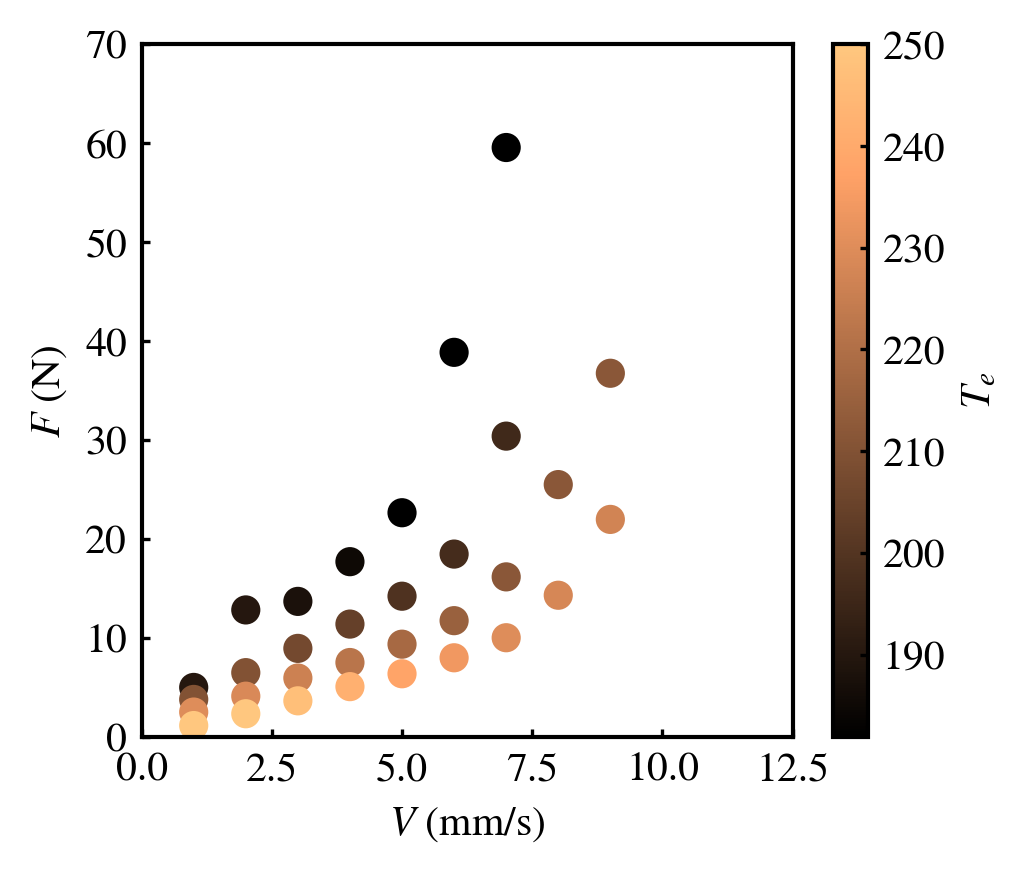

In [114]:
df = data.loc[data["材料"]=="L1003"]

cmap = plt.get_cmap("copper")
plt.scatter(df["速度"], df["压力均值.1"], c=df["出口温度"], cmap=cmap, marker="o")
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)
plt.colorbar(label="$T_e$")

## 4 Extrusion force and printability

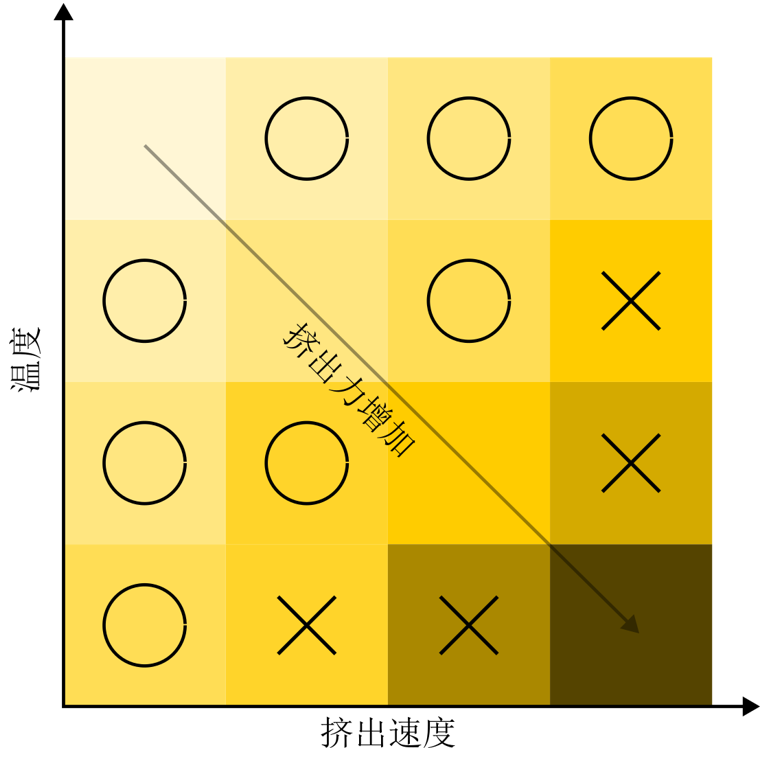

In [141]:
folder = Path(r"H:\我的云端硬盘\Polymaker\003.挤出过程研究\003.挤出测试平台\实验数据\000.规范化数据（个人用）").resolve()
data = pd.read_excel(folder / "挤出力x打印性.xlsx", sheet_name="L1003-6")

In [158]:
# find force transition
df = data.loc[(~np.isnan(data["挤出力"]))&(data["温度"]==230)]

In [159]:
find_force_transition_velocity(df, velocity_col_name="打印速度")

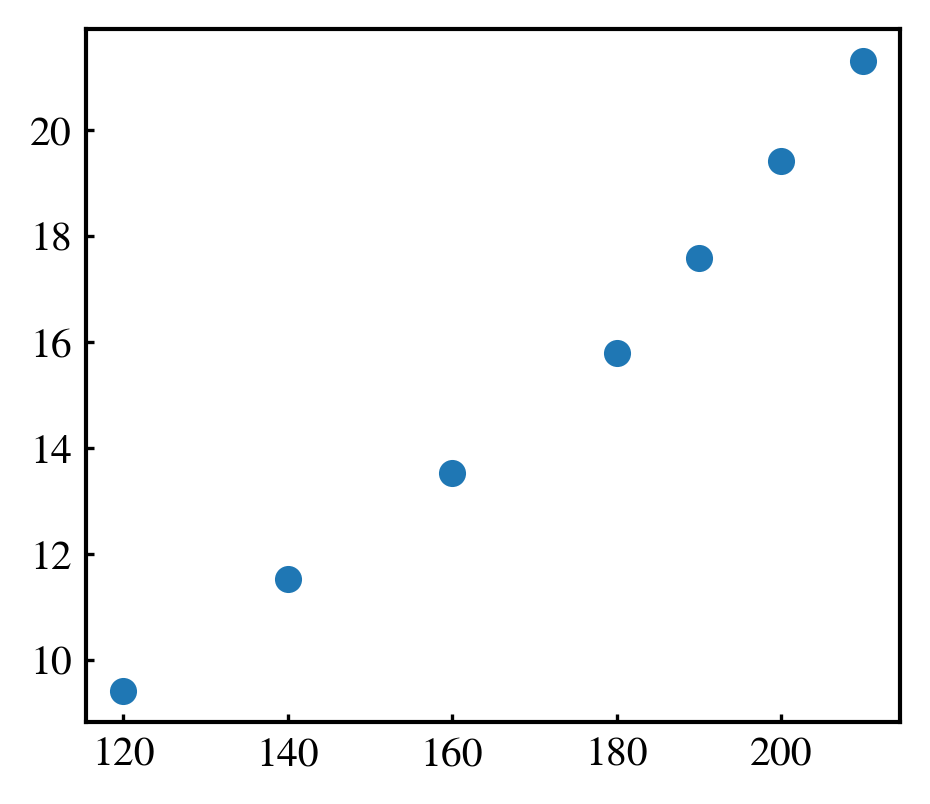

In [160]:
plt.plot(df["打印速度"], df["挤出力"], "o")

In [153]:
df

,温度,打印速度,进线速度,挤出力,挤出力标准差,网格填充,拉丝,备注
0,210,120,4.20,12.768933,0.277226,1.0,NaN,X1E
1,210,140,4.90,15.344221,0.315857,1.0,NaN,X1E
2,210,160,5.60,18.220524,0.345237,1.0,NaN,X1E
3,210,180,6.30,22.998383,0.393478,1.0,NaN,X1E
4,210,190,6.65,26.081591,0.615473,1.0,NaN,X1E
5,210,200,7.00,29.120561,0.492650,0.0,NaN,X1E
6,210,210,7.35,31.150770,0.625728,0.0,NaN,X1E
7,210,220,7.70,32.531017,1.015984,0.0,NaN,X1E


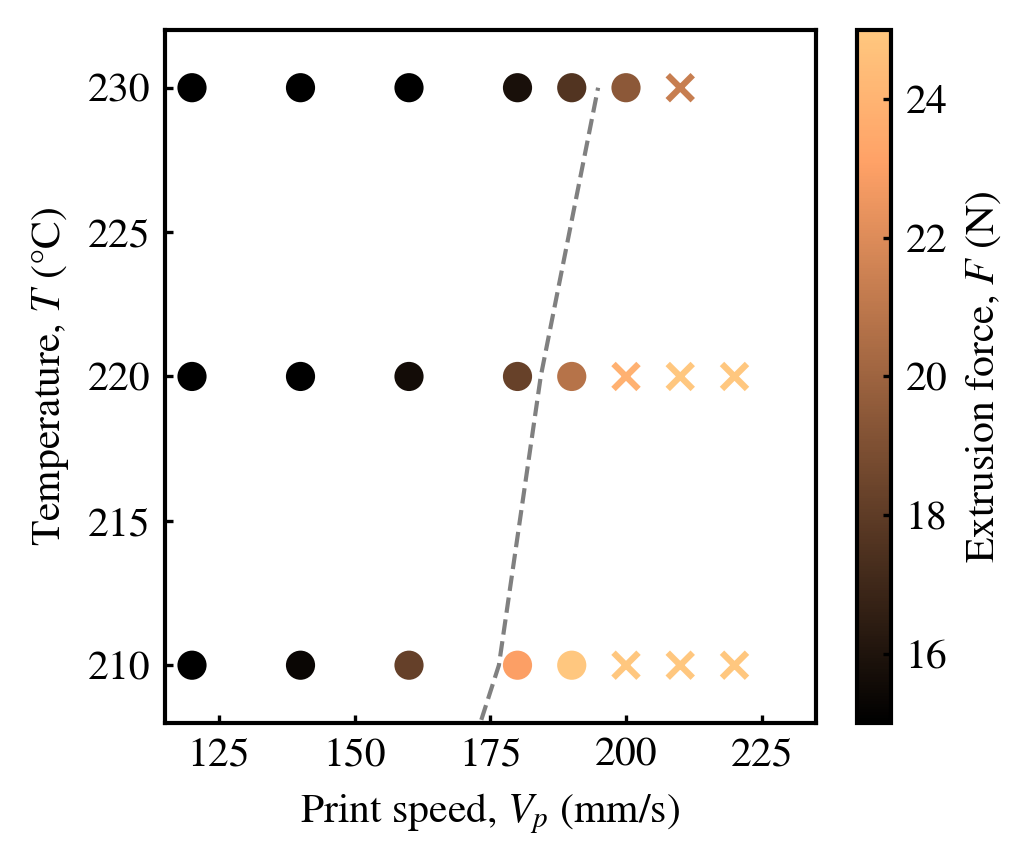

In [162]:
# separate good and bad mesh filling
good = data.loc[data["网格填充"]==1]
bad = data.loc[data["网格填充"]==0]

# make figure
norm = mcolors.Normalize(vmin=15, vmax=25)
cmap = plt.get_cmap("copper")
plt.scatter(good["打印速度"], good["温度"], c=good["挤出力"], marker="o",cmap=cmap, norm=norm)
plt.scatter(bad["打印速度"], bad["温度"], c=bad["挤出力"], marker="x", cmap=cmap, norm=norm)
plt.xlabel("Print speed, $V_p$ (mm/s)")
plt.ylabel("Temperature, $T$ (°C)")
plt.colorbar(label="Extrusion force, $F$ (N)")
plt.xlim(115, 235)
plt.ylim(208, 232)

# add a dashed line for the force transition
v_crit = np.array([5.58, 6.18, 6.45, 6.82]) / 0.035
T = [200, 210, 220, 230]
plt.plot(v_crit, T, ls="--", lw=1, color="gray", label="Force transition")

## 5 Extrusion force time series

In [14]:
data_folder = Path(r"H:\我的云端硬盘\Polymaker\003.挤出过程研究\003.挤出测试平台\实验数据\006.1002挤出力")
data = pd.read_excel(data_folder / "测试2025.09.05--15-21-s-210C.xlsx")

Text(0, 0.5, 'Extrusion force, $F$ (N)')

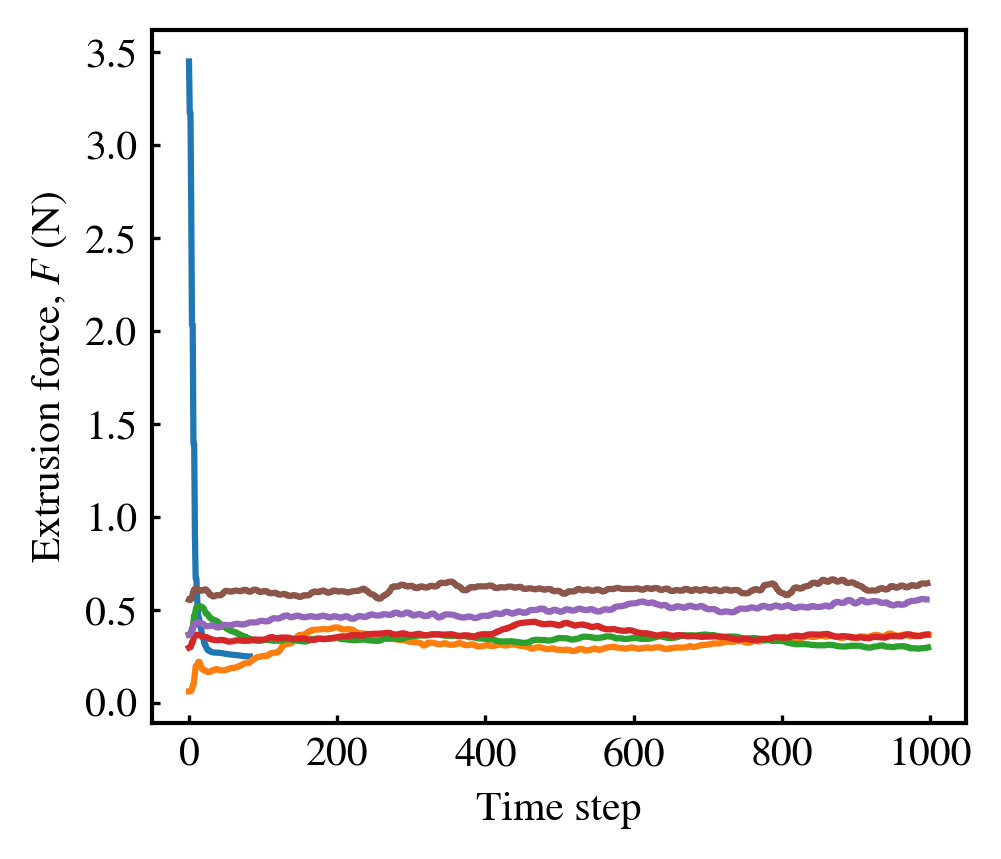

In [36]:
for v, g in data.groupby("当前速度值 mm/s"):
    if v > 6:
        continue
    plt.plot(range(len(g)), g["压力 kg"], label=f"{v} mm/s")
plt.xlabel("Time step")
plt.ylabel("Extrusion force, $F$ (N)")

### 5.1 Determine the steady regime

When speed is increased, there is always an unsteady regime, where the polymer chains in the melt adapt to the new flow condition by rearranging themselves in a new configuration. This regime is marked by a fluctuating extrusion force, typically an overshoot, which is then followed by a steady regime. 

In our simple analysis, we want to focus on the steady regime. It is desired that we can identify the steady regime algorithmically. In this section, we test the moving window idea. 

In [182]:
data_folder = Path(r"G:\Zhengyang\2025-09-16")
filename = "测试2025.09.16--10-57-s-240.xls"
data = pd.read_csv(data_folder / filename, sep="\t", encoding="gbk")
df = data.loc[(data["当前速度值 mm/s"]==2)]

Text(0, 0.5, 'Extrusion force, $F$ (N)')

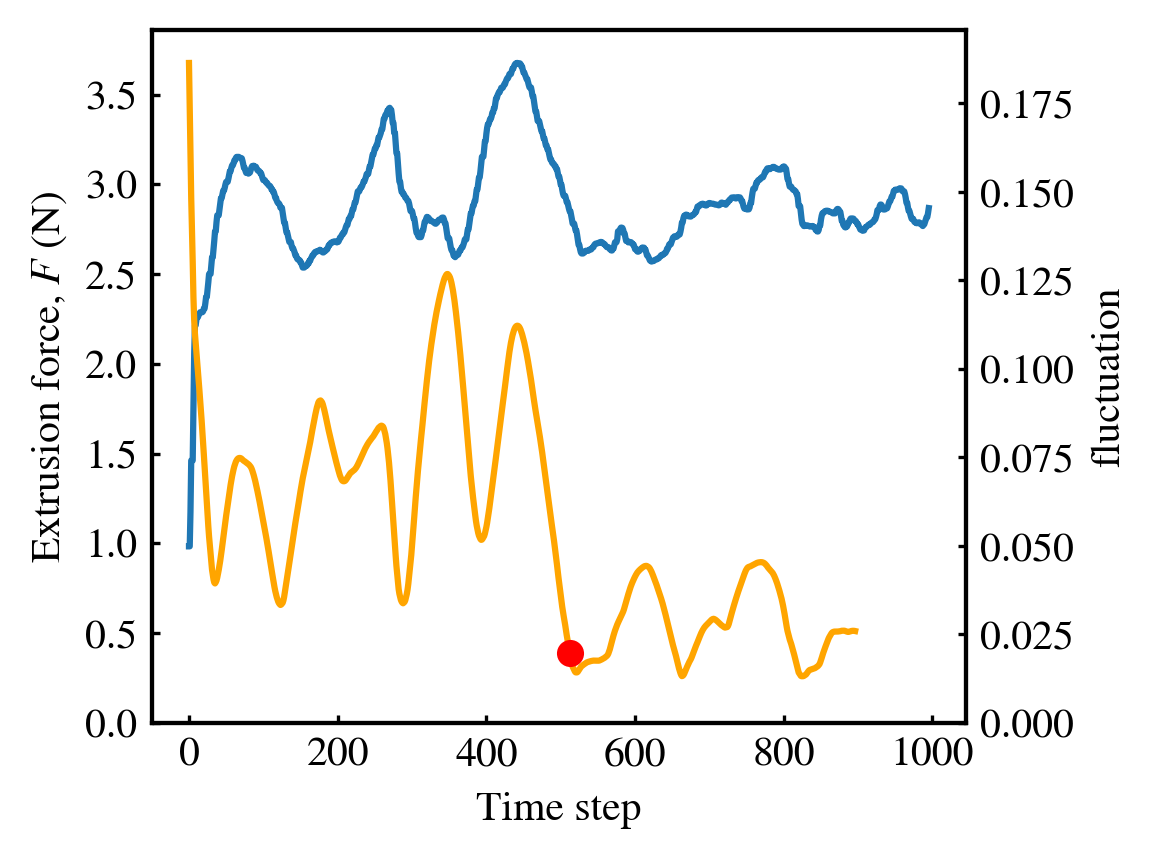

In [185]:
window_size = 99
score_list = []
force = df["压力 kg"] * 9.8
plt.plot(range(len(df)), force) 
for i in range(len(df) - window_size):
    window = df["压力 kg"][i: i+window_size] 
    score = window.std() / window.mean()
    score_list.append(score)
ax = plt.gca()
ax1 = ax.twinx()
ax1.plot(score_list, color="orange")
ax1.set_ylabel("fluctuation")

ind = np.argmin(np.sign(np.array(score_list) - 0.02))
plt.plot(ind, score_list[ind], "ro")
ax.set_ylim(0, force.max() * 1.05)
ax1.set_ylim(0, np.array(score_list).max() * 1.05)
ax.set_xlabel("Time step")
ax.set_ylabel("Extrusion force, $F$ (N)")

The following function is a more concise implementation of the method.

In [72]:
def find_steady_state_start(data_series, window_size, threshold):
    """
    Finds the index where a time series reaches a steady state.

    Args:
        data_series (pd.Series): The time series data.
        window_size (int): The number of data points in the sliding window.
        threshold (float): The standard deviation threshold to define a steady state.

    Returns:
        int: The index of the start of the steady state, or None if not found.
    """
    # reset index, ignore the original index
    data_series = data_series.reset_index(drop=True)
    
    # Calculate the rolling standard deviation
    rolling_std = data_series.rolling(window=window_size).std() / data_series.rolling(window=window_size).mean()

    # Find the first index where the rolling_std is below the threshold
    steady_state_candidates = rolling_std[rolling_std < threshold]

    if not steady_state_candidates.empty:
        # The start of the steady-state REGIME is the first point in that first window
        # So we get the index of the first window that met the criteria
        first_window_end_index = steady_state_candidates.index[0]
        # The actual start of the data regime is the beginning of that window
        steady_state_start_index = max(0, first_window_end_index - window_size + 1)
        return steady_state_start_index
    else:
        return None # No steady state found

In [74]:
find_steady_state_start(df["压力 kg"], window_size=99, threshold=0.02)

np.int64(303)

With this, we can crop the original time series to get the steady states. 

In [73]:
df = data.loc[data["当前速度值 mm/s"]==.2]

In [71]:
df.reset_index()

,index,时间,温度 ℃,压力 kg,挤出量 mm,当前步骤,当前动作,当前速度值 mm/s,设定挤出长度 mm,当前循环次数,喷头直径/mm,熔丝直径/mm,挤出胀大比
0,999,2025-09-05 15:23:07,24,0.3656,20.478,2,挤出,0.4,40,1,0.4,0,0
1,1000,2025-09-05 15:23:07,24,0.3663,20.525,2,挤出,0.4,40,1,0.4,0,0
2,1001,2025-09-05 15:23:07,24,0.3767,20.572,2,挤出,0.4,40,1,0.4,0,0
3,1002,2025-09-05 15:23:08,24,0.3767,20.572,2,挤出,0.4,40,1,0.4,0,0
4,1003,2025-09-05 15:23:08,24,0.3994,20.619,2,挤出,0.4,40,1,0.4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1992,2025-09-05 15:24:47,25,0.2942,60.867,2,挤出,0.4,40,1,0.4,0,0
994,1993,2025-09-05 15:24:47,25,0.2953,60.914,2,挤出,0.4,40,1,0.4,0,0
995,1994,2025-09-05 15:24:47,25,0.2966,60.961,2,挤出,0.4,40,1,0.4,0,0
996,1995,2025-09-05 15:24:47,25,0.2966,61.008,2,挤出,0.4,40,1,0.4,0,0


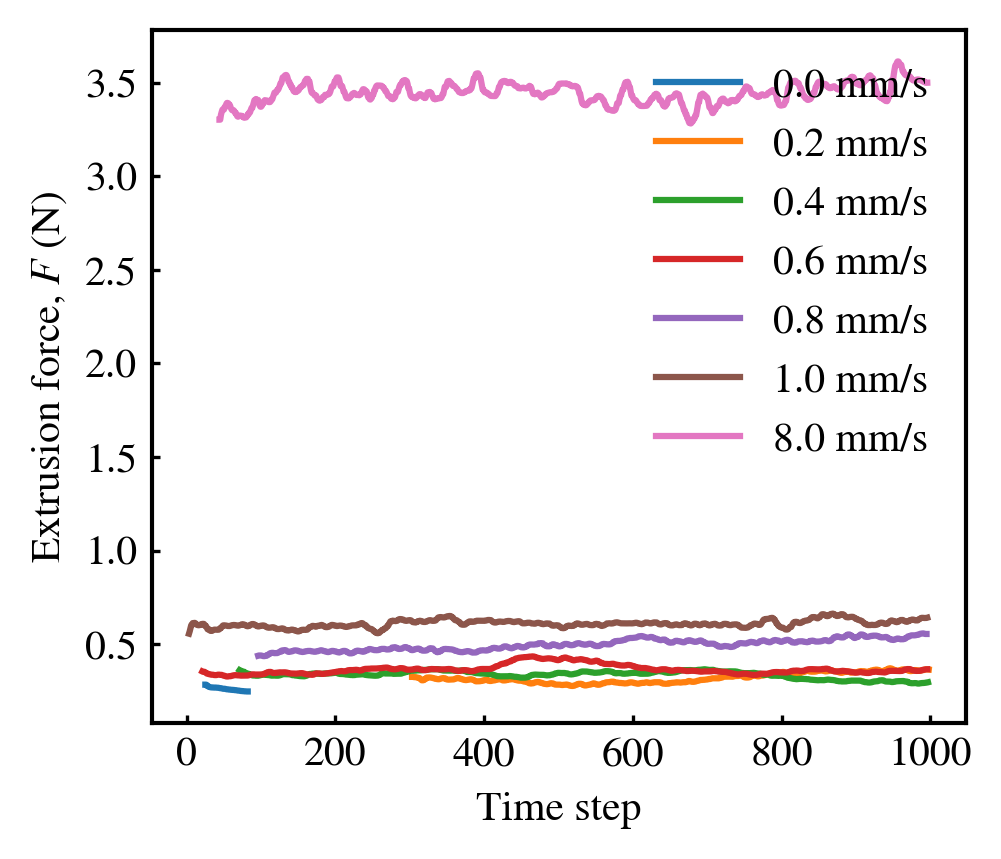

In [78]:
v_list = []
fmean_list = []
fstd_list = []
for v, g in data.groupby("当前速度值 mm/s"):
    ind = find_steady_state_start(g["压力 kg"], window_size=len(g)//10, threshold=0.02)
    if ind is not None:
        plt.plot(np.arange(len(g))[ind:], g["压力 kg"].iloc[ind:], label=f"{v} mm/s")
        v_list.append(v)
        fmean_list.append(g["压力 kg"].iloc[ind:].mean())
        fstd_list.append(g["压力 kg"].iloc[ind:].std())
plt.xlabel("Time step")
plt.ylabel("Extrusion force, $F$ (N)")
plt.legend()

We can compute mean and std from the steady state time series. 

In [100]:
data_folder = Path(r"H:\我的云端硬盘\Polymaker\003.挤出过程研究\003.挤出测试平台\实验数据\002.挤出力数据\L1003")
filename = Path("测试2025.09.15--16-03-s-230.xls")
data = pd.read_csv(data_folder / filename, sep="\t", encoding="gbk")

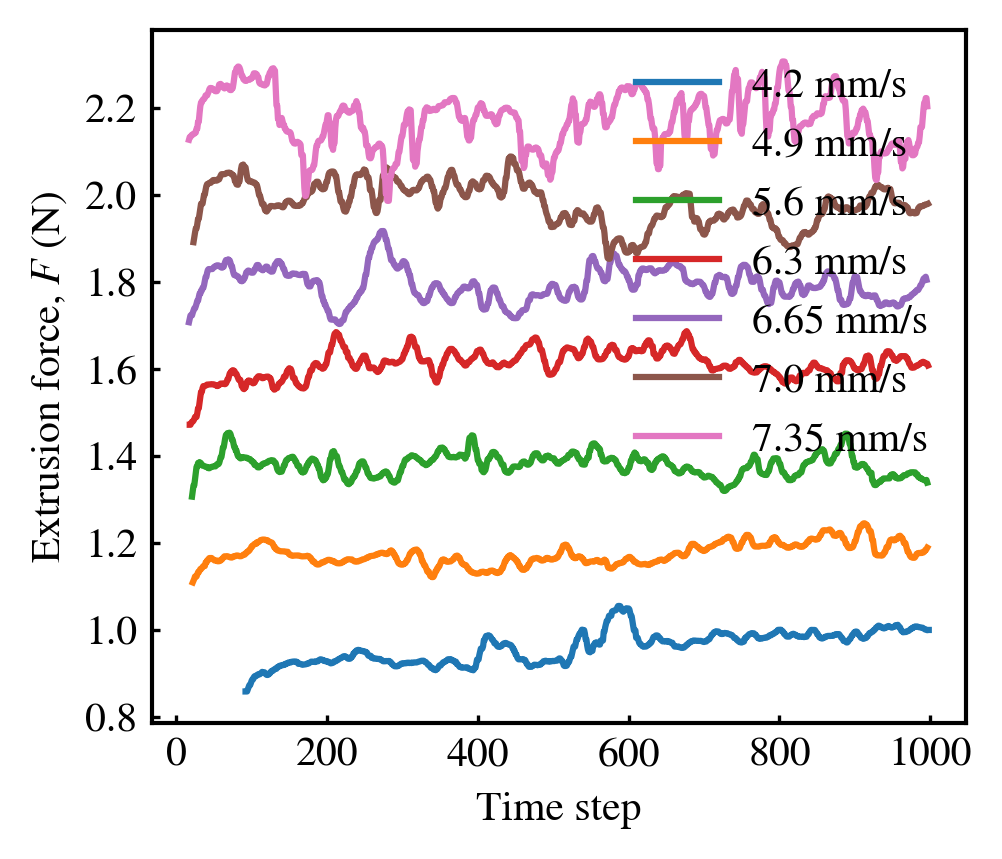

In [101]:
v_list = []
fmean_list = []
fstd_list = []
for v, g in data.groupby("当前速度值 mm/s"):
    if v == 0:
        continue
    ind = find_steady_state_start(g["压力 kg"], window_size=len(g)//10, threshold=0.02)
    if ind is not None:
        plt.plot(np.arange(len(g))[ind:], g["压力 kg"].iloc[ind:], label=f"{v} mm/s")
        v_list.append(v)
        fmean_list.append(g["压力 kg"].iloc[ind:].mean())
        fstd_list.append(g["压力 kg"].iloc[ind:].std())
plt.xlabel("Time step")
plt.ylabel("Extrusion force, $F$ (N)")
plt.legend()

<ErrorbarContainer object of 3 artists>

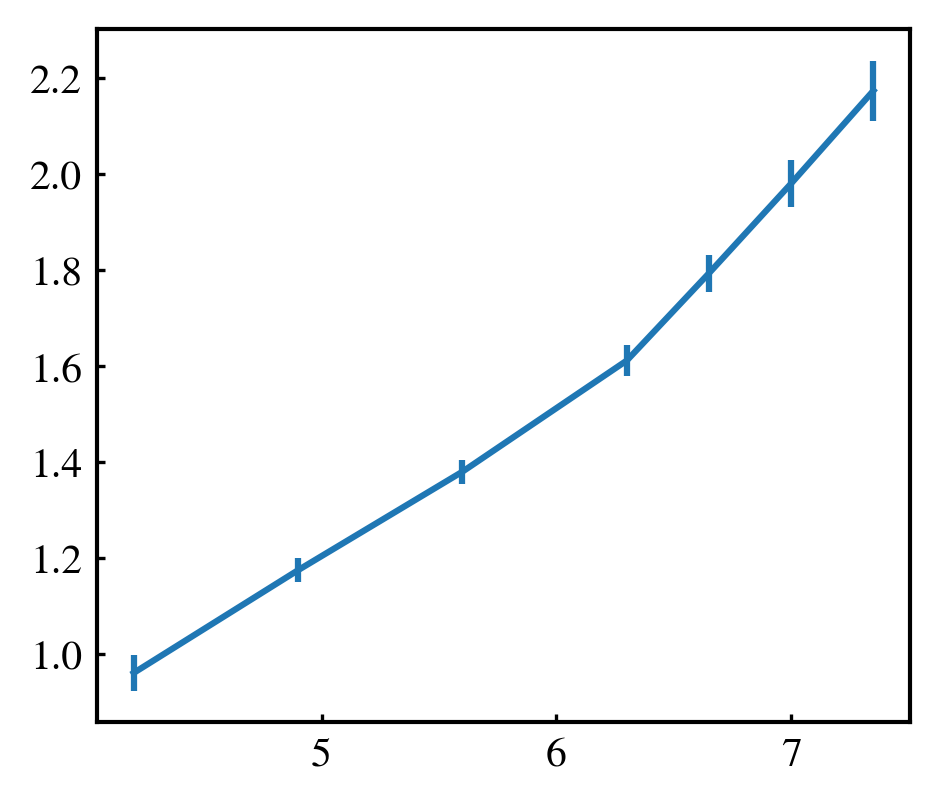

In [102]:
plt.errorbar(v_list, fmean_list, yerr=fstd_list)

In [103]:
force_data = pd.DataFrame({"velocity": v_list, "force_mean": fmean_list, "force_std": fstd_list})
force_data.to_csv(data_folder / (str(filename.name)+"_force.csv"), index=False)

## 6 Baseline determination

I have collected 